In [1]:
# import dependencies

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import DirectoryIterator
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! mkdir -p ~/.kaggle/
import os
import json 
api_token = {"username":"XXX","key":"XXX"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
   json.dump(api_token, file)

In [4]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 98% 1.13G/1.15G [00:10<00:00, 113MB/s]
100% 1.15G/1.15G [00:10<00:00, 117MB/s]


In [5]:
from zipfile import ZipFile

zf = ZipFile('chest-xray-pneumonia.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('chest_xray.zip', 'r')
zf.extractall()
zf.close()

os.chdir(os.path.join(os.getcwd(),'chest_xray'))
!ls

test  train  val


In [0]:
train_path = os.path.join(os.getcwd(),'train')
test_path = os.path.join(os.getcwd(),'test')
val_path = os.path.join(os.getcwd(),'val')

In [7]:
os.listdir(val_path)

['PNEUMONIA', '.DS_Store', 'NORMAL']

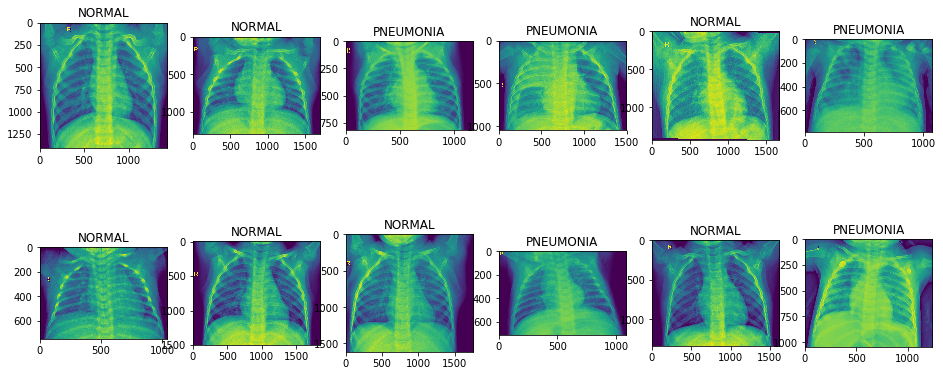

In [8]:
# plot sample images
s = np.random.choice(['PNEUMONIA','NORMAL'],size=12)
img_dest=[os.path.join(train_path,i) for i in s]
plt.figure(figsize = (16,7))
for i in range(len(s)):
  plt.subplot(2,6,i+1)
  plt.title(s[i])
  img_name=np.random.choice(os.listdir(img_dest[i]))
  img = plt.imread(os.path.join(img_dest[i],img_name))
  plt.imshow(img)

# Using Keras/Tensorflow

In [9]:
rescale = 1./255
target_size = (150, 150)
batch_size = 32
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale = rescale,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
from sklearn.utils import class_weight
def get_weight(y):
  class_weight_current = class_weight.compute_class_weight('balanced', np.unique(y), y)
  return class_weight_current

In [11]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [12]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    restore_best_weights = True)


callbacks = [es]

In [0]:
#from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.layers.normalization import BatchNormalization
from keras.models import Model
def get_model():
  base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.4)(x)
  predictions = Dense(2, activation='softmax')(x)
  print(predictions)

  model = Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable=False
  model.summary()

  return model

In [95]:
model = get_model()

Tensor("dense_8/Softmax:0", shape=(?, 2), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 74, 74, 32)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 74, 74, 32)   0           batch_normalization_189[0][0]    
___________________________________

In [0]:
model.save('init.h5')

In [0]:
from keras.models import load_model
model = load_model('init.h5')

In [96]:
from keras import optimizers

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

optimizer = optimizers.Adam(lr=0.00001, decay=1e-6)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
epochs = 100

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=epochs, 
                              verbose = 2, 
                              callbacks=callbacks,
                              validation_data = validation_generator,
                              validation_steps = validation_steps,
                              class_weight=class_weight)
print(f'Completed Model Training')

Epoch 1/100
 - 78s - loss: 0.6804 - acc: 0.6543 - val_loss: 1.0502 - val_acc: 0.5000
Epoch 2/100
 - 66s - loss: 0.5574 - acc: 0.7452 - val_loss: 0.7288 - val_acc: 0.6250
Epoch 3/100
 - 68s - loss: 0.5030 - acc: 0.7766 - val_loss: 0.7555 - val_acc: 0.6250
Epoch 4/100
 - 68s - loss: 0.4444 - acc: 0.8106 - val_loss: 0.6164 - val_acc: 0.6875
Epoch 5/100
 - 67s - loss: 0.4133 - acc: 0.8298 - val_loss: 0.5202 - val_acc: 0.7500
Epoch 6/100
 - 67s - loss: 0.3766 - acc: 0.8457 - val_loss: 0.5979 - val_acc: 0.7500
Epoch 7/100
 - 67s - loss: 0.3639 - acc: 0.8493 - val_loss: 0.6476 - val_acc: 0.7500
Epoch 8/100
 - 66s - loss: 0.3415 - acc: 0.8597 - val_loss: 0.6449 - val_acc: 0.6875
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
Completed Model Training


In [0]:
scores = model.evaluate_generator(test_generator)

In [134]:
scores[1]

0.7035256410256411

# Using fast.ai and resnet34

In [22]:
!curl -s https://course.fast.ai/setup/colab | bash
from fastai import *
from fastai.vision import *

Updating fastai...
Done.


In [23]:
path = Path(os.getcwd())
path

PosixPath('/content/chest_xray')

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.3,
        ds_tfms=get_transforms(do_flip='True', max_zoom=0.), size=224, num_workers=4).normalize(imagenet_stats)

In [75]:
data.classes

['NORMAL', 'PNEUMONIA']

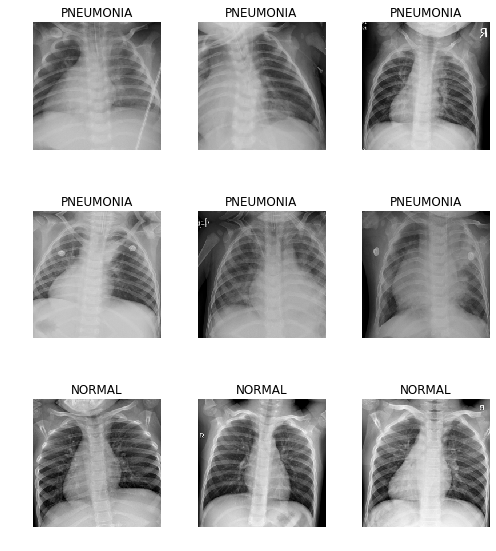

In [76]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
import torchvision.models as TorchModels
inceptionModel = TorchModels.inception_v3(pretrained=True)

In [0]:
train = cnn_learner(data, models.resnet34, metrics=error_rate)

In [79]:
train.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.381187,0.227108,0.078588,03:43
1,0.250716,0.186526,0.079157,03:37
2,0.195656,0.165682,0.065490,03:33
3,0.166073,0.155682,0.063781,03:32


In [0]:
train.unfreeze()

In [83]:
train.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


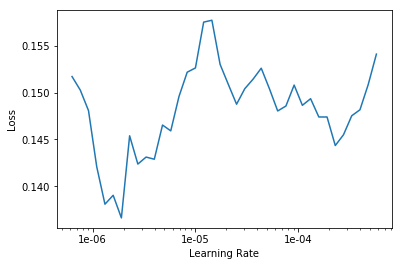

In [84]:
train.recorder.plot()

In [85]:
train.fit_one_cycle(5, max_lr=slice(1e-8,1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.149570,0.160251,0.065490,03:36
1,0.163293,0.152703,0.062073,03:33
2,0.159810,0.167191,0.066629,03:33
3,0.154654,0.162925,0.067198,03:33
4,0.162464,0.153086,0.058656,03:34
